**1. Підготовка середовища**

In [193]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [194]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**2. Завантаження та попередня обробка даних**

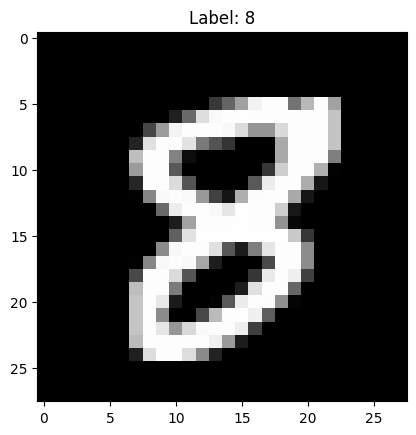

In [195]:
# Трансформація зображення
transform = transforms.Compose([
    transforms.ToTensor()  # Перетворює зображення в тензор та нормалізує від 0.0 до 1.0
])

# Завантаження набору даних MNIST + розділення на train/test датасет
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train = True,
                                           download=True,
                                           transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train = False,
                                          download=True,
                                          transform=transform)

#image.shape
#розмірність torch.Size([1, 28, 28])

#f"Train: {len(train_dataset.data)}", f"Test: {len(test_dataset.data)}"
#('Train: 60000', 'Test: 10000')


# Розмір батчу
batch_size = 32 #64

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)


class_names = train_dataset.classes

# Перевірка прикладу зображення
examples = iter(train_loader)
example_data, example_targets = next(examples)
plt.imshow(example_data[0][0], cmap='gray')
plt.title(f'Label: {example_targets[0]}')
plt.show()


**3. Створення архітектури нейронної мережі**

**4. Налаштування параметрів навчання**

In [196]:
#Час виконання
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


# Метрика правильності
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [197]:
#Перетворюємо на к-сть вхідних нейронів(28*28)
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x) # perform forward pass
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [198]:
#Створюємо класс з базовою моделлю
class SimpleNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super(SimpleNN, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = output_shape)
        )

    def forward(self, x):
      # return self.layer_2(self.layer_1(x))
      return self.layer_stack(x)

torch.manual_seed(42)
model = SimpleNN(input_shape = output.shape[1],
                 hidden_units = 16,
                 output_shape = len(train_dataset.classes)
)


#Ініціалізація функцію втрати та оптимізатор(SGD)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = model.parameters(), lr = 0.1)

**5. Навчання моделі**

In [199]:
#from content.helper_functions import accuracy_fn
from tqdm.auto import tqdm
torch.manual_seed(42)
train_time_start_on_cpu = timer()


# Тренування моделі
epochs = 5
loss_train_all = []
acc_train_all = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    #Тренування
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(train_loader):

      model.train()

      # Прямий прохід
      #y_pred = model(X)
      y_logits = model(X)
      y_pred = torch.softmax(y_logits, dim = 1)

      # Дивимося втрати
      loss = loss_fn(y_logits, y)
      train_loss += loss

      # Визначаємо точність
      train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))


      # Зворотній прохід та оптимізація
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #Результат
      if batch % 400 == 0:
          print(f'Looked at {batch * len(X)}/{len(train_loader.dataset)} samples')

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    ### Тестування

    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in test_loader:

            # Прямий прохід
            #test_pred = model(X)
            test_logits = model(X)
            test_pred = torch.softmax(test_logits, dim = 1)

            # Дивимося втрати
            test_loss += loss_fn(test_logits, y)

            # Визначаємо точність
            test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim=1))

        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

    ## Результат
    print(f"\nTrain loss: {train_loss:.5f} Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

    loss_train_all.append(train_loss)
    acc_train_all.append(train_acc)

# Рахуємо витрачений час
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu,
                                           end = train_time_end_on_cpu,
                                           device = str(next(model.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47354 Train acc: 85.20% | Test loss: 0.22499, Test acc: 93.01%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.22053 Train acc: 93.45% | Test loss: 0.17406, Test acc: 94.60%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.18278 Train acc: 94.54% | Test loss: 0.15897, Test acc: 95.30%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.16468 Train acc: 95.03% | Test loss: 0.18310, Test acc: 94.40%

Epoch: 4
-------
Looked at 0/600

In [200]:
scalar_loss_list = [t.item() for t in loss_train_all]

**Побудуйте графік втрат та точності під час навчання**

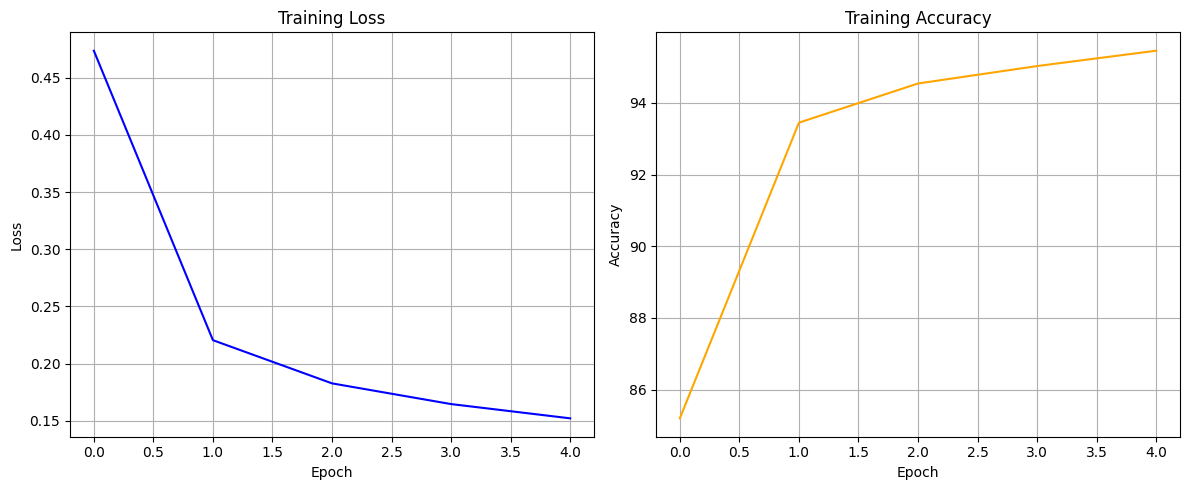

In [201]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 рядок, 2 стовпці

# Перший графік (Loss)
ax[0].plot(scalar_loss_list, label='Loss', color='blue')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')
ax[0].grid(True)

# Другий графік (Accuracy)
ax[1].plot(acc_train_all, label='Accuracy', color='orange')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training Accuracy')
ax[1].grid(True)

# Відображення
plt.tight_layout()  # Для коректного розміщення
plt.show()

**Оцінка моделі**

In [202]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):

    loss, acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true = y,
                                y_pred = y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Рахуємо точність та витрати на тестовому наборі
model_results = eval_model(model = model,
                           data_loader = test_loader,
                           loss_fn = loss_fn,
                           accuracy_fn = accuracy_fn,
                           device = device
)

model_results

{'model_name': 'SimpleNN',
 'model_loss': 0.15119454264640808,
 'model_acc': 95.52715654952077}

**Confusion Matrix**

In [203]:
from tqdm.auto import tqdm

y_preds = []

model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc = "Making predictions"):

    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim = 1).argmax(dim = 1)

    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

mlxtend version: 0.23.3


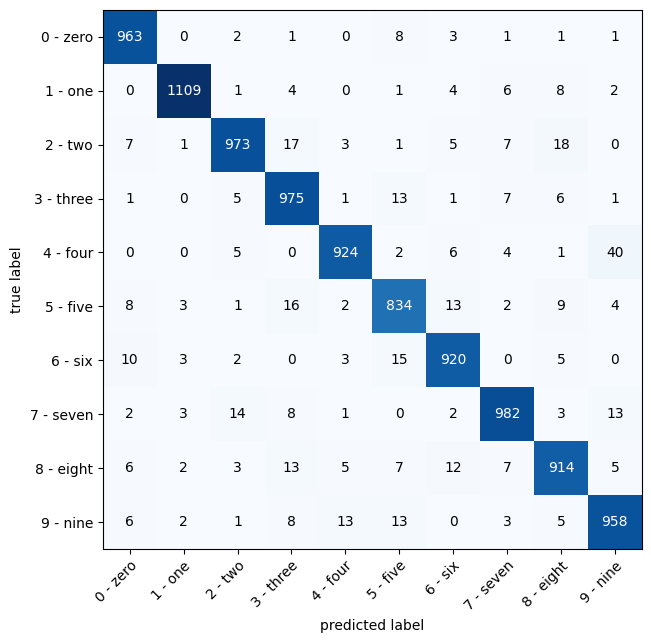

In [204]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")


from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


confmat = ConfusionMatrix(num_classes = len(class_names), task = 'multiclass')
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_dataset.targets)

fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                                class_names = class_names,
                                figsize=(10, 7)
);

**Візуалізація результатів**

In [205]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:

            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [206]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2 (2 - two)


In [207]:
pred_probs = make_predictions(model = model,
                              data = test_samples)

In [208]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

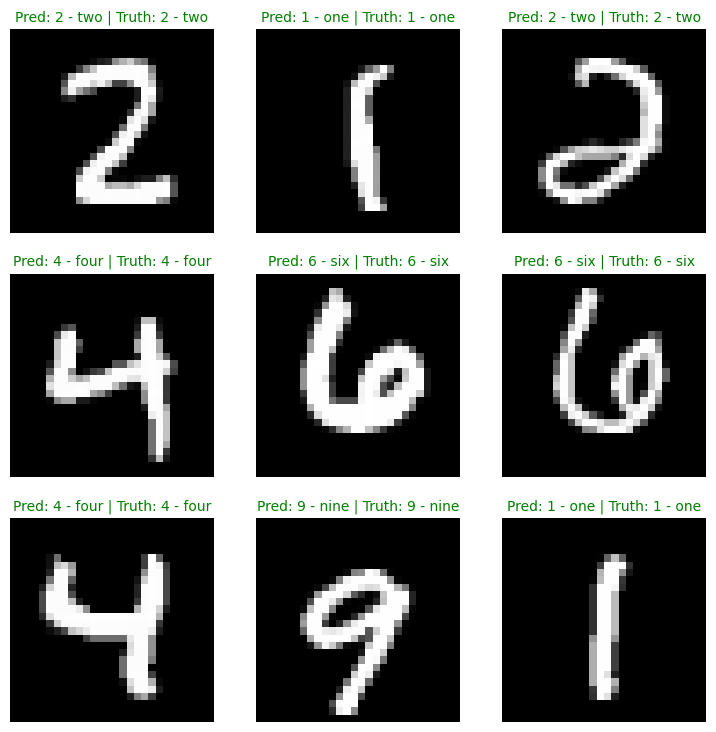

In [209]:
# Plot predictions
plt.figure(figsize = (9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);